In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

In [92]:
missing_index.size()

torch.Size([36, 8759])

In [94]:
torch.where((torch.sum(missing_index, dim = 0) > 1) & (torch.sum(missing_index, dim = 0) < 18))[0].size()

torch.Size([1532])

In [102]:
class MultiRBFnnTime(nn.Module):
    def __init__(self, in_feature, add_rbf_num, device):
        super(MultiRBFnnTime, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features
        self.device = device
        self.centers_list = []
        self.sigmas_list = []
        self.weights_list = []
        self.Mulitcenters_list = []
        self.Multisigmas_list = []
        self.Multiweights_list = []


        self.change_th = 3
    
    def find_longest_continuous_sequence(self, tensor, add_rbf_num):
        center_index_list = []

        for _ in range(add_rbf_num):
            max_length = 0
            current_length = 0
            max_start_index = 0

            for i in range(1, tensor.size(0)):
                if tensor[i] == tensor[i-1] + 1:
                    current_length += 1
                    if current_length > max_length:
                        max_length = current_length
                        max_start_index = i - max_length
                else:
                    current_length = 0

            center_value = tensor[(max_start_index + (max_start_index + max_length + 1)) // 2]
            center_index_list.append(center_value.unsqueeze(0))

            # 중심값을 제외한 다음 연속된 수열을 찾기 위해 텐서에서 해당 값들 제거
            tensor = tensor[(tensor < tensor[max_start_index]) | (tensor > tensor[max_start_index] + max_length)]
        center_index_list = torch.cat(center_index_list)

        return center_index_list

    def first_rbf_parameter(self, input_data, target, masking): # done

        # input_data shape : (data_num)
        # target data shape : (in_feature, data_num)
        
        # first layer centers, weights, sigmas
        # centers, sigmas : (add_rbf_num, 1)
        # weights : (in_feature, add_rbf_num)

        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()

        find_sigma = masking.clone().detach()
        find_weight = target.clone().detach()
        center_index_list = []

        # first MultiRBFs initial centers and weights parameters
        for i in range(self.add_rbf_num):
            index_ = torch.argmax(torch.sum(torch.abs(fine_index_target), dim = 0)).cpu().detach().tolist()
            fine_index_target[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device= self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)

        # first MultiRBFs initial sigmas parameters                

        initsigma = torch.index_select(find_sigma, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)

        masked = torch.where((torch.sum(self.rbf_masking, dim = 0) > 1) & (torch.sum(self.rbf_masking, dim = 0) < (self.in_feature // 2 + 1)))[0]

        MultiCenter_list = self.find_longest_continuous_sequence(masked, self.add_rbf_num)
        Multicenter = torch.index_select(find_index_input, 0, MultiCenter_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        Multiweight = torch.index_select(find_weight, 1, MultiCenter_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)
        Multiweight = torch.max(Multiweight, dim = 0)[0].reshape(1, self.add_rbf_num)
        print(Multiweight)
        
        Multisigma = torch.index_select(find_sigma, 0, MultiCenter_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)

        return initcenter, initweight, initsigma, Multicenter, Multiweight, Multisigma
    
    def add_rbf_parameter(self, input_data, error, masking):
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = masking.clone().detach()
        
        center_index_list = []

        for i in range(self.add_rbf_num * (self.change_time + 1)):
            index_ = torch.argmax(torch.sum(torch.abs(find_index_error), dim = 0)).cpu().detach().tolist()

            find_index_error[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)


        initsigma = torch.index_select(find_sigma, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)

        
        masked = torch.where((torch.sum(self.rbf_masking, dim = 0) > 1) & (torch.sum(self.rbf_masking, dim = 0) < (self.in_feature // 2 + 1)))[0]
        MultiCenter_list = self.find_longest_continuous_sequence(masked, self.add_rbf_num * (self.change_time + 1))
        
        Multicenter = torch.index_select(find_index_input, 0, MultiCenter_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        Multiweight = torch.index_select(find_weight, 1, MultiCenter_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)

        Multiweight = torch.max(Multiweight, dim = 0)[0].reshape(1, self.add_rbf_num)
        print(Multiweight)
        Multisigma = torch.index_select(find_sigma, 0, MultiCenter_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)

        return initcenter, initweight, initsigma, Multicenter, Multiweight, Multisigma
    
    def masking_of_target(self, target, ratio):
        rbf_masking = target.clone().detach()
        indices = torch.nonzero(rbf_masking == 1)  # 배열에서 값이 1인 인덱스 추출
        num_ones = indices.size(0)  # 값이 1인 요소의 개수

        num_zeros_to_replace = int(num_ones * ratio)  # 바꿀 1의 개수 계산
        if num_zeros_to_replace > 0:
            chosen_indices = torch.randperm(num_ones)[:num_zeros_to_replace]  # 바꿀 1의 인덱스를 무작위로 선택

            for index in chosen_indices:
                rbf_masking[indices[index][0], indices[index][1]] = 0  # 선택된 인덱스의 값을 0으로 변경

        return rbf_masking
    
    
    def rbf_gaussian(self, input_data):
        out = torch.exp(-1 *(torch.pow((input_data - self.centers), 2)) / (2 * torch.pow(self.sigma, 2)))

        return out
    
    def rbf_multi(self, input_data):
        out = torch.exp(-1*(torch.pow((input_data - self.Multicenter), 2)) / (2 * torch.pow(self.Multisigma, 2)))
        
        return out

    def forward(self, input_data):
        R = self.rbf_gaussian(input_data)
        R_multi = self.rbf_multi(input_data)

        pred = torch.mm(self.weights, R) + torch.mm(self.Multiweight, R_multi)

        return R, R_multi, pred

    def rbf_gaussian_derivative_centers(self, input_data): # done
        output = ((input_data - self.centers) / (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)

    def rbf_gaussian_derivative_sigma(self, input_data): # done
        output = (4 * torch.pow((input_data - self.centers), 2) / (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)
    
    def Multi_derivative_centers(self, input_data):
        output = ((input_data - self.Multicenter) / (torch.pow(self.Multisigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def Multi_derivative_sigma(self, input_data):
        output = (4 * torch.pow((input_data - self.Multicenter), 2) / (torch.pow(self.Multisigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    # FUNCTION GRADIENT
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        for i in range(target.size(0)):
            if i == 0:
                f_grad = torch.gradient(target[i], spacing = space, edge_order  = 1)[0]
            else:
                f_grad = torch.vstack([f_grad, torch.gradient(target[i], spacing = space, edge_order  = 1)[0]])
        return f_grad
    
    def target_grad_compute(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    

    def L2_F(self, input_data):
        return -2 * (input_data - self.centers) / torch.pow(self.sigma, 2)
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.centers) / torch.pow(self.sigma,2)) * radial_output
    
    def masking(self, target):
    
        # value_masking vector
        value_masking = torch.where(target.isnan(), 0.0, 1.0).to(torch.float64)
        
        return value_masking
    
    def time_interval(self, masking):
        interval = torch.zeros_like(masking)
        for m in range(masking.size(0)):
            for i in range(masking.size(1)):
                after = 0
                before = 0
                after_index = i + 1
                before_index = i - 1
                if i == 0:
                    while after == 0 and after_index < masking.size(1):
                        if masking[m][after_index] != 1:
                            after_index += 1
                        else:
                            after = 1
                            interval[m][i] = (after_index - i) / 2
                elif i == masking.size(1)-1:
                    while before == 0 and before_index > -1:
                        if masking[m][before_index] != 1:
                            before_index -= 1
                        else:
                            before = 1
                            interval[m][i] = (i - before_index) / 2 
                else:
                    after = 0
                    before = 0
                    while before == 0 and before_index > -1:
                        if masking[m][before_index] != 1:
                            before_index -= 1
                        else:
                            before = 1
                    while after == 0 and after_index < masking.size(1):
                        if masking[m][after_index] != 1:
                            after_index += 1
                        else:
                            after = 1
                    interval[m][i] = (after_index - before_index) / 2
        return torch.mean(interval, axis = 0)
                
    # Backpropagation and train

    def BP(self, input_data, target, R, R_multi, pred):

        pred = pred * self.rbf_masking

        L2_1_error = -2 * (target - pred)

        observation_len = torch.sum(self.rbf_masking)

        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaSigma1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaSigma = torch.sum(torch.sum(deltaSigma1, dim=2), dim = 0) / observation_len

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaCenter1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaCenter =  torch.sum(torch.sum(deltaCenter1, dim=2), dim = 0) / observation_len
        
        # weight update
        delta_weight1 = torch.sum((R * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))), dim=2)
        delta_weight = delta_weight1 / observation_len

        # Multi RBF update
        MultiSigma1 = self.Multi_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        MultiSigma1 *= self.Multiweight.reshape(1, self.add_rbf_num, 1)

        MultiSigma = torch.sum(torch.sum(MultiSigma1, dim=2), dim = 0) / observation_len

        MultiCenter1 = self.Multi_derivative_centers(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        MultiCenter1 *= self.Multiweight.reshape(1, self.add_rbf_num, 1)

        MultiCenter =  torch.sum(torch.sum(MultiCenter1, dim=2), dim = 0) / observation_len

        Multiweight1 = torch.sum((R_multi * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))), dim=2)
        Multiweight = torch.sum(Multiweight1, dim = 0) / observation_len

        # BP update
        self.weights -= self.lr * delta_weight
        self.centers -= self.lr * deltaCenter.reshape(self.add_rbf_num, 1)
        self.sigma -= self.lr * deltaSigma.reshape(self.add_rbf_num, 1)

        self.Multiweight -= self.lr * Multiweight.reshape(1, self.add_rbf_num)
        self.Multicenter -= self.lr * MultiCenter.reshape(self.add_rbf_num, 1)
        self.Multisigma -= self.lr * MultiSigma.reshape(self.add_rbf_num, 1)


    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1
    
    def plot_train(self, input_data, best_pred, pred_single, pred_multi): #done
        masking_index = torch.ones_like(self.rbf_masking) - self.rbf_masking
        best_pred_masking = best_pred
        if self.in_feature != 1:
            fig, ax = plt.subplots(1, self.in_feature, figsize = (40, 5))
            for i in range(self.in_feature):
                ax[i].scatter(input_data.cpu().detach().numpy(), torch.nan_to_num(self.target[i]).cpu().detach().numpy())
                ax[i].scatter(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
                ax[i].scatter(input_data[masking_index[i] != 0].cpu().detach().numpy(), best_pred[i][masking_index[i] != 0].cpu().detach().numpy())
                ax[i].scatter(input_data.cpu().detach().numpy(), pred_single[i].cpu().detach().numpy())
                ax[i].scatter(input_data.cpu().detach().numpy(), pred_multi[0].cpu().detach().numpy(), c = "darkred")

            plt.show()
        
        else:
            plt.scatter(input_data.cpu().detach().numpy(), torch.nan_to_num(self.target[0]).cpu().detach().numpy())
            plt.scatter(input_data.cpu().detach().numpy(), best_pred_masking[0].cpu().detach().numpy())
            plt.show()

    def best_forward(self, input_data, best_center, best_sigma, best_weight,best_MC, best_MS, best_MW): # ?
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                        (2 * torch.pow(best_sigma, 2))))
        
        MultiR = torch.exp(-1 * (torch.pow((input_data - best_MC), 2) / \
                                        (2 * torch.pow(best_MS, 2))))
        
        pred = torch.mm(best_weight, rbf_output) + torch.mm(best_MW, MultiR)

        return pred, torch.mm(best_weight, rbf_output), torch.mm(best_MW, MultiR)
    
    def Loss(self, pred, target, pred_grad, true_grad):
        # value L2 loss  
        pred *= self.value_masking
        pred_grad *= self.value_masking

        x_loss = 0
        x_loss += self.value_loss(pred, target)
        x_loss += self.gradinet_loss(pred_grad, true_grad) 

        return x_loss
    
    def value_loss(self, pred, target):
        # pred = pred * self.value_masking
        return torch.sum(torch.abs(pred - target)) /torch.sum(self.value_masking)
    
    def gradinet_loss(self, pred_grad, true_grad):
        # pred_grad *= self.value_masking
        return torch.sum(torch.abs(pred_grad - true_grad)) /torch.sum(self.value_masking)
    
    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_centers), 2) / \
                                     (2 * torch.pow(self.done_sigma, 2))))
        MR = torch.exp(-1 * (torch.pow((input_data - self.done_MC), 2) / \
                                     (2 * torch.pow(self.done_MS, 2))))

        pred = torch.mm(self.done_weights, rbf_output) + torch.mm(self.done_MW, MR)

        return rbf_output, pred
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th, masking_rate = 0.5):
        self.lr = lr
        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.lr_change_th = lr_change_th
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.round_number = 5
        self.change_time = 0
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_num

        loss = 100000
        
        while self.loss_th < loss:

            print("{}th additional rbflayer".format(self.number))
            # first rbflayer
            if self.number == 0:
                self.value_masking = self.masking(self.target)

                self.rbf_masking = self.masking_of_target(self.value_masking, masking_rate)
                time_inter = self.time_interval(self.rbf_masking)
                self.step_target = torch.nan_to_num(self.target) * self.rbf_masking

                self.centers, self.weights, self.sigma, self.Multicenter, self.Multiweight, self.Multisigma = self.first_rbf_parameter(input_data, self.step_target, time_inter)

                for epoch in range(epochs):
                    R, R_multi, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights) 

                    self.BP(input_data, self.step_target, R,R_multi, pred)
                    R, R_multi, pred = self.forward(input_data)
                    epoch_loss = self.value_loss(pred, torch.nan_to_num(self.target))

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch, epoch_loss))
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                        self.best_MW = self.Multiweight.clone().detach()
                        self.best_MS = self.Multisigma.clone().detach()
                        self.best_MC = self.Multicenter.clone().detach()

                    
                    else:
                        if self.best_loss > epoch_loss:
                            self.best_loss = epoch_loss.clone().detach()
                            self.best_center = self.centers.clone().detach()
                            self.best_sigma = self.sigma.clone().detach()
                            self.best_weight = self.weights.clone().detach()
                            self.best_MW = self.Multiweight.clone().detach()
                            self.best_MS = self.Multisigma.clone().detach()
                            self.best_MC = self.Multicenter.clone().detach()


                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                    
                # print(self.sigma)

            else:
                self.change_init(na)
                if self.change_time > break_time:
                    break

                # rbf_masking
                self.rbf_masking = self.masking_of_target(self.value_masking, masking_rate)
                self.step_target = torch.nan_to_num(self.target) * self.rbf_masking
                
                
                self.centers, self.weights, self.sigma, self.Multicenter, self.Multiweight, self.Multisigma = self.add_rbf_parameter(input_data, self.step_target, time_inter)
                # print(self.sigma)
                for epoch in range(epochs):
                    # print('epoch : {}'.format(epoch))
                    R,R_multi, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    if epoch == 0:
                        
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch,
                                                                                        self.value_loss(pred, torch.nan_to_num(self.target))))
                        
                        self.best_loss = self.value_loss(pred, torch.nan_to_num(self.target))
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                        self.best_MW = self.Multiweight.clone().detach()
                        self.best_MS = self.Multisigma.clone().detach()
                        self.best_MC = self.Multicenter.clone().detach()


                    self.BP(input_data, self.step_target, R,R_multi, pred)
                    R, R_multi,pred = self.forward(input_data)

                    epoch_loss = self.value_loss(pred, torch.nan_to_num(self.target))

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                    
                    if self.best_loss > epoch_loss:
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                        self.best_MW = self.Multiweight.clone().detach()
                        self.best_MS = self.Multisigma.clone().detach()
                        self.best_MC = self.Multicenter.clone().detach()

            best_pred, pred_single, pred_multi = self.best_forward(input_data, self.best_center, self.best_sigma, self.best_weight, self.best_MC, self.best_MS, self.best_MW)

            if self.number ==0:
                train_loss = self.value_loss(best_pred, torch.nan_to_num(self.target))
            else:
                train_loss = self.value_loss(best_pred, torch.nan_to_num(self.target))

            print("{}th additional RBFlayer best loss : {}".format(self.number, train_loss))

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.01
                print("change lr ", self.lr)
                print('----------------------------------------------')
                
            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')
                
            self.train_loss_list.append(train_loss)

            # additional rbf plot print
            self.plot_train(input_data, best_pred, pred_single, pred_multi)

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.centers_list.append(self.best_center)
                self.sigmas_list.append(self.best_sigma)
                self.weights_list.append(self.best_weight)

                self.Mulitcenters_list.append(self.best_MC)
                self.Multisigmas_list.append(self.best_MS)
                self.Multiweights_list.append(self.best_MW)

                self.done_centers = torch.cat(self.centers_list, dim = 0)
                self.done_sigma = torch.cat(self.sigmas_list, dim = 0)
                self.done_weights = torch.cat(self.weights_list, dim = 1)

                self.done_MC = torch.cat(self.Mulitcenters_list, dim = 0)
                self.done_MS = torch.cat(self.Multisigmas_list, dim = 0)
                self.done_MW = torch.cat(self.Multiweights_list, dim = 1)

            else:
                na = 0

In [103]:
df = pd.read_csv("../dataset/pm25_missing.txt").drop(['datetime'], axis = 1)
df = df[df.columns[:10]].reset_index(drop=True)
target = torch.tensor(df.values).T.to(device).reshape(10,len(df))
input = torch.tensor(df.index + 1, dtype=float).to(device)

0th additional rbflayer
tensor([[ 29.,  43., 100.,  73.,  91., 136.,  39.,  12.,  19., 116.]],
       device='cuda:0', dtype=torch.float64)
0th additional RBFlayer 0th epoch loss: 166.70839351174078
0th additional RBFlayer 999th epoch MSE Loss: 92.66571372568525
0th additional RBFlayer 1999th epoch MSE Loss: 88.86129381081771
0th additional RBFlayer 2999th epoch MSE Loss: 88.88624901675188
0th additional RBFlayer best loss : 88.7905529455053


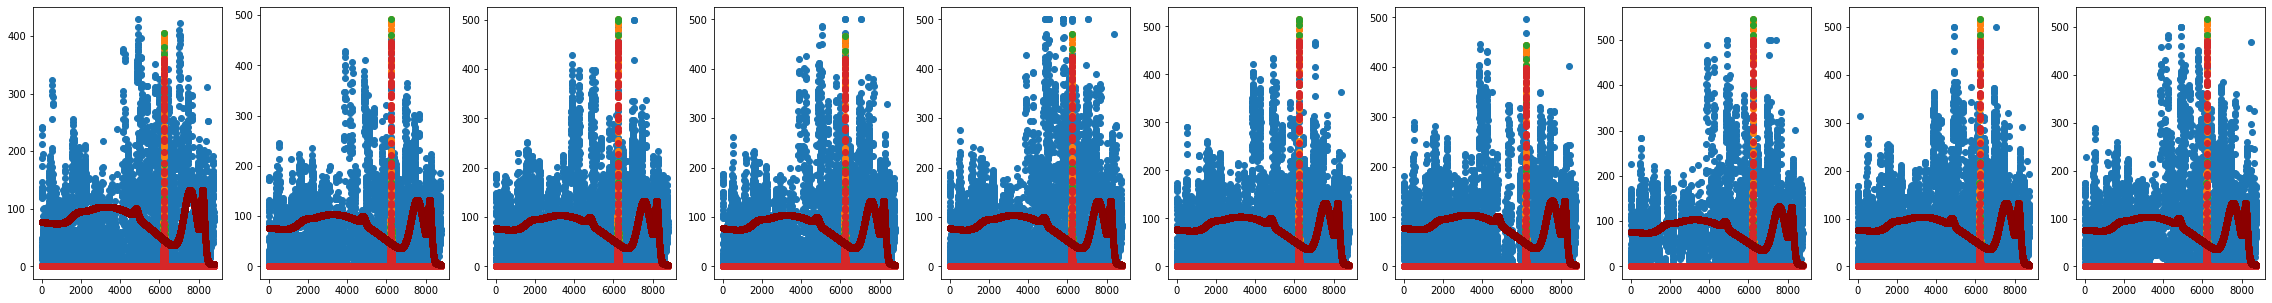

1th additional rbflayer
tensor([[ 0.0000,  0.0000, 23.4670,  0.0000,  0.0000, 59.3825,  0.0000,  0.0000,
          0.0000,  0.0000]], device='cuda:0', dtype=torch.float64)
1th additional RBFlayer 0th epoch loss: 67.42635279071219
1th additional RBFlayer 999th epoch MSE Loss: 64.89680265050771
1th additional RBFlayer 1999th epoch MSE Loss: 63.495952668140696
1th additional RBFlayer 2999th epoch MSE Loss: 62.95074815918463
1th additional RBFlayer best loss : 62.18058073693117


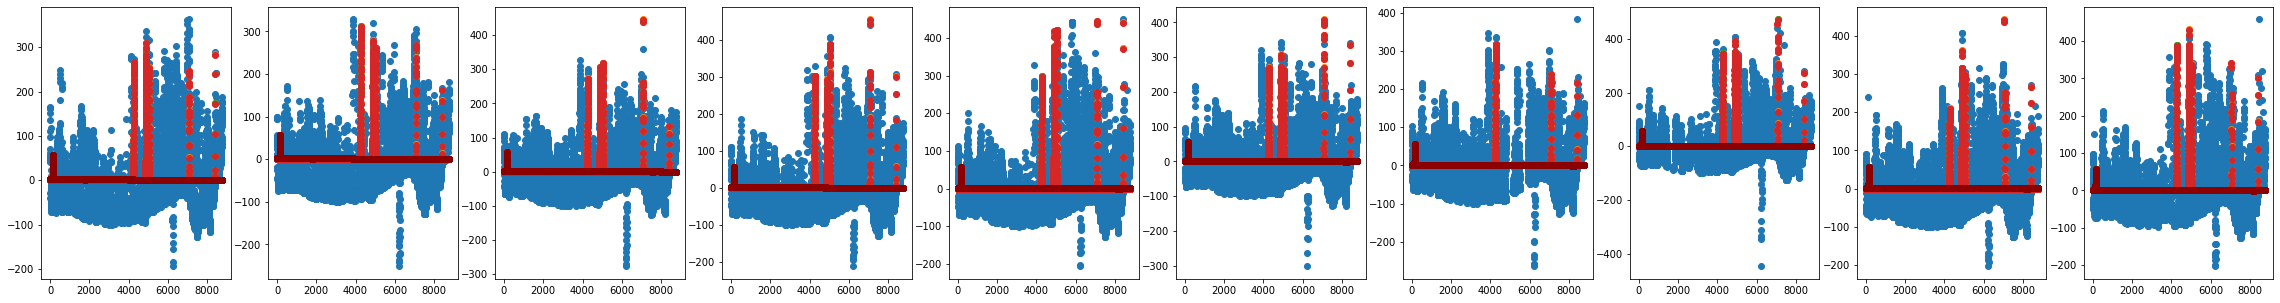

2th additional rbflayer
tensor([[ 0.0000,  0.0000, 20.4172,  0.0000,  0.0000,  2.3373,  0.0000,  0.0000,
          0.0000,  0.0000]], device='cuda:0', dtype=torch.float64)
2th additional RBFlayer 0th epoch loss: 63.3327522176985
2th additional RBFlayer 999th epoch MSE Loss: 58.89826764789622
2th additional RBFlayer 1999th epoch MSE Loss: 58.820653326386825
2th additional RBFlayer 2999th epoch MSE Loss: 58.92821904014079
2th additional RBFlayer best loss : 58.81355505146516


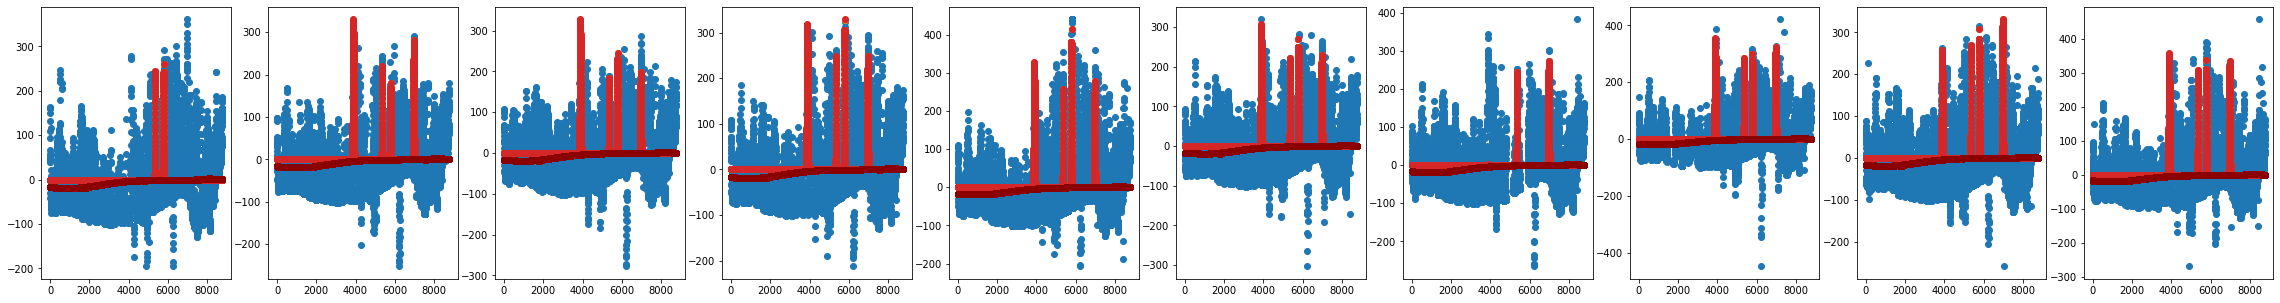

3th additional rbflayer
tensor([[ 0.0000,  0.0000, 37.9338,  0.0000,  0.0000, 19.7422,  0.0000,  0.0000,
          0.0000,  0.0000]], device='cuda:0', dtype=torch.float64)
3th additional RBFlayer 0th epoch loss: 55.54056462242382
3th additional RBFlayer 999th epoch MSE Loss: 58.45286607905722
3th additional RBFlayer 1999th epoch MSE Loss: 55.967927388405684
3th additional RBFlayer 2999th epoch MSE Loss: 55.56389049715174
3th additional RBFlayer best loss : 55.54056462242382


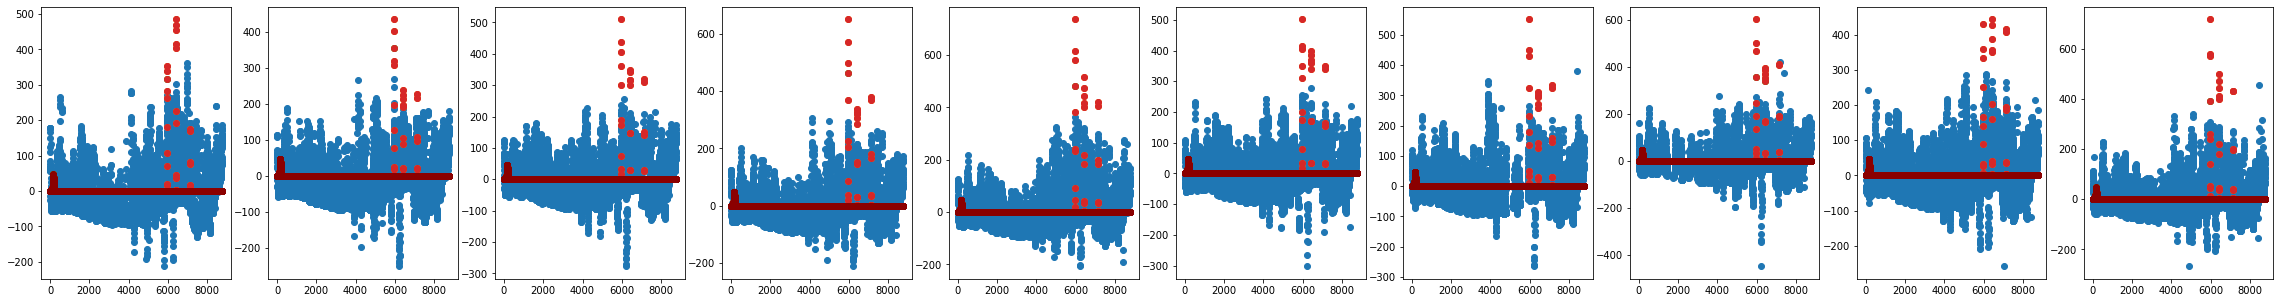

4th additional rbflayer
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       dtype=torch.float64)
4th additional RBFlayer 0th epoch loss: 55.49087464273659
4th additional RBFlayer 999th epoch MSE Loss: 53.97608473394113


KeyboardInterrupt: 

In [104]:
model = MultiRBFnnTime(10, 10, device)
model.train(input, target, 3000, 1e-3, 15, 15, 0.0)